In [5]:
import lmdb
import numpy as np
from pathlib import Path
from random import sample, choice
from io import BytesIO
from PIL import Image

## Data

In [6]:
env = lmdb.open(
    str(Path("data") / "DocTamperV1-SCD"),
    readonly=True,
    lock=False,
    readahead=False,
    meminit=False
)

def list_files_codes(env: lmdb.Environment):
    '''
    List files awailable in the lmdb.Environment.

    Parameters
    ----------
    env: lmdb.Environment
        Environment from wich files must me loaded.
    '''
    with env.begin(write=False) as txn:
        with txn.cursor() as cursor:
            decoded: list[str] = [key.decode('utf-8') for key, _ in cursor]
            image_predix = "image-"
            return [
                name[len(image_predix):] 
                for name in decoded if name.startswith(image_predix)
            ]

In [7]:
files_codes = sample(population=list_files_codes(env=env), k=20)
test_path = Path("test")
test_path.mkdir(exist_ok=True)


with env.begin(write=False) as txn:
    for code in files_codes:
        img_buf = txn.get(f'image-{code}'.encode('utf-8'))
        label_buf = txn.get('label-{code}'.encode('utf-8'))

        Image.open(BytesIO(img_buf)).save(test_path/f"{code}.jpg")

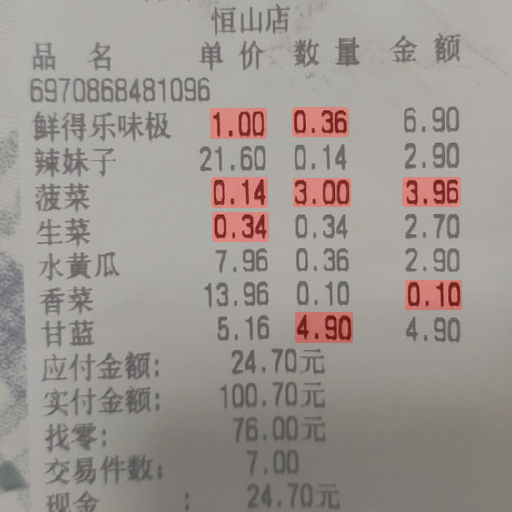

In [9]:
index = choice(list_files_codes(env=env))

with env.begin(write=False) as txn:
    img_buf = txn.get(f'image-{index}'.encode('utf-8'))
    label_buf = txn.get(f'label-{index}'.encode('utf-8'))

image = Image.open(BytesIO(img_buf)).convert("RGBA")

mask = Image.open(BytesIO(label_buf))
mask = np.array(mask)

mask = np.transpose(
    np.stack([
        np.where(mask == 255, 255, 0),
        np.zeros_like(mask),
        np.zeros_like(mask),
        np.where(mask == 255, 255, 0)
    ]),
    (1,2,0)
)
mask = Image.fromarray(mask.astype(np.uint8))

Image.blend(im1=image, im2=mask, alpha=0.3)

## Model

In [24]:
import sys
sys.path.append(str(Path().resolve()/"models"))
from swins import BasicLayer, SwinTransformerBlock, WindowAttention, Mlp, PatchMerging


import torch
from torch import nn
from models.dtd import seg_dtd

import torchvision
from albumentations.pytorch import ToTensorV2
import tempfile

from tqdm import tqdm

In [15]:
device=torch.device("cpu")
model = seg_dtd("", 2).to(device)
model = nn.DataParallel(model)
loader = torch.load(Path("pths")/"dtd_sroie.pth", map_location='cpu')['state_dict']
model.load_state_dict(loader)

<All keys matched successfully>

In [13]:
def crop_img(img, jpg_dct, crop_size=512, mask=None):
    if mask is None:
        use_mask=False
    else:
        use_mask=True
        crop_masks = []

    h, w, c = img.shape
    h_grids = h // crop_size
    w_grids = w // crop_size

    crop_imgs = []
    crop_jpe_dcts = []

    for h_idx in range(h_grids):
        for w_idx in range(w_grids):
            x1 = w_idx * crop_size
            x2 = x1 + crop_size
            y1 = h_idx * crop_size
            y2 = y1 + crop_size
            crop_img = img[y1:y2, x1:x2, :]
            crop_imgs.append(crop_img)
            crop_jpe_dct = jpg_dct[y1:y2, x1:x2]
            crop_jpe_dcts.append(crop_jpe_dct)
            if use_mask:
                if mask[y1:y2, x1:x2].max()!=0:
                    crop_masks.append(1)
                else:
                    crop_masks.append(0)

    if w%crop_size!=0:
        for h_idx in range(h_grids):
            y1 = h_idx * crop_size
            y2 = y1 + crop_size
            crop_imgs.append(img[y1:y2,w-512:w,:])
            crop_jpe_dcts.append(jpg_dct[y1:y2,w-512:w])
            if use_mask:
                if mask[y1:y2,w-512:w].max()!=0:
                    crop_masks.append(1)
                else:
                    crop_masks.append(0)

    if h%crop_size!=0:
        for w_idx in range(w_grids):
            x1 = w_idx * crop_size
            x2 = x1 + crop_size
            crop_imgs.append(img[h-512:h,x1:x2,:])
            crop_jpe_dcts.append(jpg_dct[h-512:h,x1:x2])
            if use_mask:
                if mask[h-512:h,x1:x2].max()!=0:
                    crop_masks.append(1)
                else:
                    crop_masks.append(0)

    if w%crop_size!=0 and h%crop_size!=0:
        crop_imgs.append(img[h-512:h,w-512:w,:])
        crop_jpe_dcts.append(jpg_dct[h-512:h,w-512:w])
        if use_mask:
            if mask[h-512:h,w-512:w].max()!=0:
                crop_masks.append(1)
            else:
                crop_masks.append(0)

    if use_mask:
        return crop_imgs, crop_jpe_dcts, h_grids, w_grids, crop_masks
    else:
        return crop_imgs, crop_jpe_dcts, h_grids, w_grids, None


def combine_img(imgs, h_grids, w_grids, img_h, img_w, crop_size=512):
    i = 0
    re_img = np.zeros((img_h, img_w))
    for h_idx in range(h_grids):
        for w_idx in range(w_grids):
            x1 = w_idx * crop_size
            x2 = x1 + crop_size
            y1 = h_idx * crop_size
            y2 = y1 + crop_size
            re_img[y1:y2, x1:x2] = imgs[i]
            i += 1

    if w_grids*crop_size<img_w:
        for h_idx in range(h_grids):
            y1 = h_idx * crop_size
            y2 = y1 + crop_size
            re_img[y1:y2,img_w-512:img_w]=imgs[i]
            i+=1

    if h_grids*crop_size<img_h:
        for w_idx in range(w_grids):
            x1 = w_idx * crop_size
            x2 = x1 + crop_size
            re_img[img_h-512:img_h,x1:x2]=imgs[i]
            i+=1

    if w_grids*crop_size<img_w and h_grids*crop_size<img_h:
        re_img[img_h-512:img_h,img_w-512:img_w] = imgs[i]

    return re_img

totsr = ToTensorV2()
toctsr =torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.455, 0.406), std=(0.229, 0.224, 0.225))
    ])
model.eval()
crop_masks_alls = []
pred_lists_alls = []

In [28]:
data_path = Path("test")
result_path = Path("result")
result_path.mkdir(exist_ok=True)

In [32]:
import cv2
import jpegio
import os

new_qtb = np.array([
        [ 2,  1,  1,  2,  2,  4,  5,  6],
        [ 1,  1,  1,  2,  3,  6,  6,  6],
        [ 1,  1,  2,  2,  4,  6,  7,  6],
        [ 1,  2,  2,  3,  5,  9,  8,  6],
        [ 2,  2,  4,  6,  7, 11, 10,  8],
        [ 2,  4,  6,  6,  8, 10, 11,  9],
        [ 5,  6,  8,  9, 10, 12, 12, 10],
        [ 7,  9, 10, 10, 11, 10, 10, 10]
    ],
    dtype=np.int32
).reshape(64,).tolist()

In [33]:

for path in tqdm(data_path.iterdir()):
    if str(path).endswith(("jpg", 'jpeg', 'JPG', 'JPEG')):
        img_path = str(path)
        path = str(path)
        imgs_ori = cv2.imread(img_path)
        h,w,c = imgs_ori.shape
        jpg_dct = jpegio.read(img_path)
        gt_mask = cv2.imread('test_masks/'+path[:-4]+'.png',0)
        dct_ori = jpg_dct.coef_arrays[0].copy()
        use_qtb2 = jpg_dct.quant_tables[0].copy()
        if min(h,w)<512:
            H,W = gt_mask.shape[:2]
            if H < 512:
                dh = (512-H)
            else:
                dh = 0
            if W < 512:
                dw = (512-W)
            else:
                dw = 0
            imgs_ori = np.pad(imgs_ori,((0,dh),(0,dw),(0,0)),'constant',constant_values=255)
            with tempfile.NamedTemporaryFile(delete=True) as tmp:
                imgs_ori = Image.fromarray(imgs_ori).convert("L")
                imgs_ori.save(tmp,"JPEG",qtables={0:new_qtb})
                jpg = jpegio.read(tmp.name)
                dct_ori = jpg.coef_arrays[0].copy()
                imgs_ori = np.array(imgs_ori.convert('RGB'))
                use_qtb2 = jpg.quant_tables[0].copy()
            h,w,c = imgs_ori.shape

        if h%8 == 0 and w%8 == 0:
            imgs_d = imgs_ori
            dct_d = dct_ori
        else:
            imgs_d = imgs_ori[0:(h//8)*8,0:(w//8)*8,:].copy()
            dct_d = dct_ori[0:(h//8)*8,0:(w//8)*8].copy()

        qs = torch.LongTensor(use_qtb2)
        img_h, img_w, _ = imgs_d.shape
        crop_imgs, crop_jpe_dcts, h_grids, w_grids, _= crop_img(imgs_d, dct_d, crop_size=512, mask=gt_mask)
        img_list = []
        for idx, crop in enumerate(crop_imgs):
            crop = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            data = toctsr(crop)
            dct = torch.LongTensor(crop_jpe_dcts[idx])

            data, dct, qs = data.unsqueeze(0).to(device), dct.unsqueeze(0).to(device), qs.unsqueeze(0).to(device)
            dct = torch.abs(dct).clamp(0,20)
            B,C,H,W = data.shape
            qs = qs.reshape(B,1,8,8)
            with torch.no_grad():
                if data.size()[-2:]==torch.Size((512,512))  and dct.size()[-2:]==torch.Size((512,512)) and qs.size()[-2:]==torch.Size((8,8)):
                    pred = model(data,dct,qs)
                    pred = torch.nn.functional.softmax(pred,1)[:,1].cpu()
                    img_list.append(((pred.cpu().numpy())*255).astype(np.uint8))
        ci = combine_img(img_list, h_grids, w_grids, img_h, img_w, crop_size=512)
        padding = (0, 0, w-img_w, h-img_h)
        ci = cv2.copyMakeBorder(ci, padding[1], padding[3], padding[0], padding[2], cv2.BORDER_CONSTANT, value=[0, 0, 0])
        cv2.imwrite(os.path.join(result_path, path.split(".jpg")[0]+".png"), ci)

0it [00:00, ?it/s][ WARN:0@1443.167] global loadsave.cpp:241 findDecoder imread_('test_masks/test/000004518.png'): can't open/read file: check file path/integrity
1it [00:00,  1.77it/s][ WARN:0@1443.734] global loadsave.cpp:241 findDecoder imread_('test_masks/test/000002290.png'): can't open/read file: check file path/integrity
2it [00:01,  1.84it/s][ WARN:0@1444.262] global loadsave.cpp:241 findDecoder imread_('test_masks/test/000004323.png'): can't open/read file: check file path/integrity
3it [00:01,  1.86it/s][ WARN:0@1444.790] global loadsave.cpp:241 findDecoder imread_('test_masks/test/000015947.png'): can't open/read file: check file path/integrity
4it [00:02,  1.86it/s][ WARN:0@1445.333] global loadsave.cpp:241 findDecoder imread_('test_masks/test/000011764.png'): can't open/read file: check file path/integrity
5it [00:02,  1.87it/s][ WARN:0@1445.857] global loadsave.cpp:241 findDecoder imread_('test_masks/test/000008246.png'): can't open/read file: check file path/integrity
6i